In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn 
import torch.optim as optim

from model.fedformer.fedformer import FEDformer

In [2]:
def fun(x, freq=1):
    return x + np.sin(x*freq)  - freq

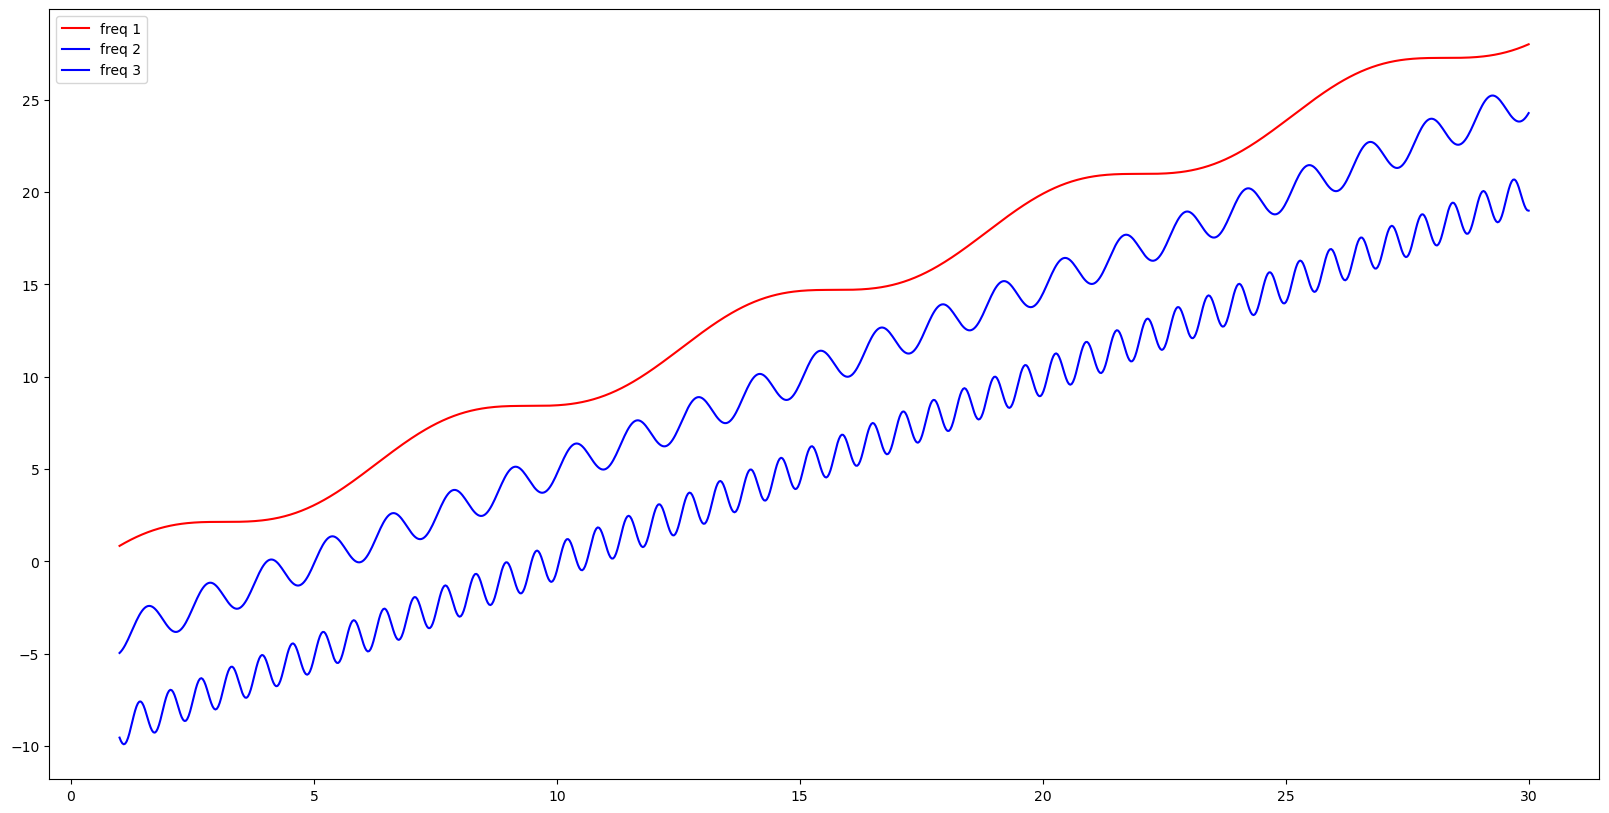

In [3]:
x = np.linspace(1, 30, 1000)
y1 = fun(x)
y2 = fun(x, freq=5)
y3 = fun(x, freq=10)

plt.figure(figsize=(20, 10))
plt.plot(x, y1, c="red", label="freq 1")
plt.plot(x, y2, c="blue", label="freq 2")
plt.plot(x, y3, c="blue", label="freq 3")
plt.legend()

In [4]:
class DS(Dataset):
    def __init__(self, c_w=10, t_w=3):
        super().__init__()
        x = torch.linspace(1, 60, 1000)
        y1 = x+torch.sin(x) - 1
        y2 = x+torch.sin(5*x) - 5
        y3 = x+torch.sin(10*x) - 10
        self.y = torch.cat([y1.unsqueeze(1), y2.unsqueeze(1), y3.unsqueeze(1)], dim=1)
        self.c_w=c_w
        self.t_w=t_w

    def __len__(self):
        return len(self.y) - self.c_w - self.t_w
    
    def __getitem__(self, index):
        start = index
        end_c = index + self.c_w
        end_t = end_c + self.t_w
        feat = self.y[start:end_c]
        tar = self.y[end_c:end_t]
        return feat, tar

In [7]:
c_w, t_w = 32, 1

DEVICE="cpu"
LR=1e-3
BS=128

model = FEDformer(seq_len=c_w, label_len=10, pred_len=t_w, modes=16, enc_in=3, dec_in=3, c_out=3, cat_size=None,
                  moving_avg=[4, 8], e_layers=2, d_layers=2, n_heads=4, d_model=256, d_ff=512, dp=0.05)

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

dataset = DS(c_w=c_w, t_w=t_w)
train_idx = [i for i in range(0, int(len(dataset)*0.8))]
test_idx = [i for i in range(int(0.8*len(dataset)), len(dataset))]

trainset = Subset(dataset, train_idx)
testset = Subset(dataset, test_idx)

trainloader = DataLoader(trainset, batch_size=BS)
testloader = DataLoader(testset, batch_size=BS)


In [9]:
for epoch in range(10):    
    epoch_loss=0
    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        pred = model(inputs)
        loss = criterion(pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(f'for epoch {epoch+1} ; loss is {epoch_loss}')

for epoch 1 ; loss is 5.236478477716446
for epoch 2 ; loss is 2.8421326130628586
for epoch 3 ; loss is 1.5933636277914047
for epoch 4 ; loss is 0.8232729956507683
for epoch 5 ; loss is 0.5934186577796936
for epoch 6 ; loss is 0.37889621779322624
for epoch 7 ; loss is 0.2827361151576042
for epoch 8 ; loss is 0.2487943135201931
for epoch 9 ; loss is 0.1951412670314312
for epoch 10 ; loss is 0.1655489755794406


In [10]:
train_true, train_tar = [], []
model.eval()
with torch.no_grad():
    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        pred = model(inputs)
        train_true.append(targets)
        train_tar.append(pred)

train_true = torch.cat(train_true)
train_tar = torch.cat(train_tar)

In [11]:
test_true, test_tar = [], []
model.eval()
with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        pred = model(inputs)
        test_true.append(targets)
        test_tar.append(pred)

test_true = torch.cat(test_true)
test_tar = torch.cat(test_tar)

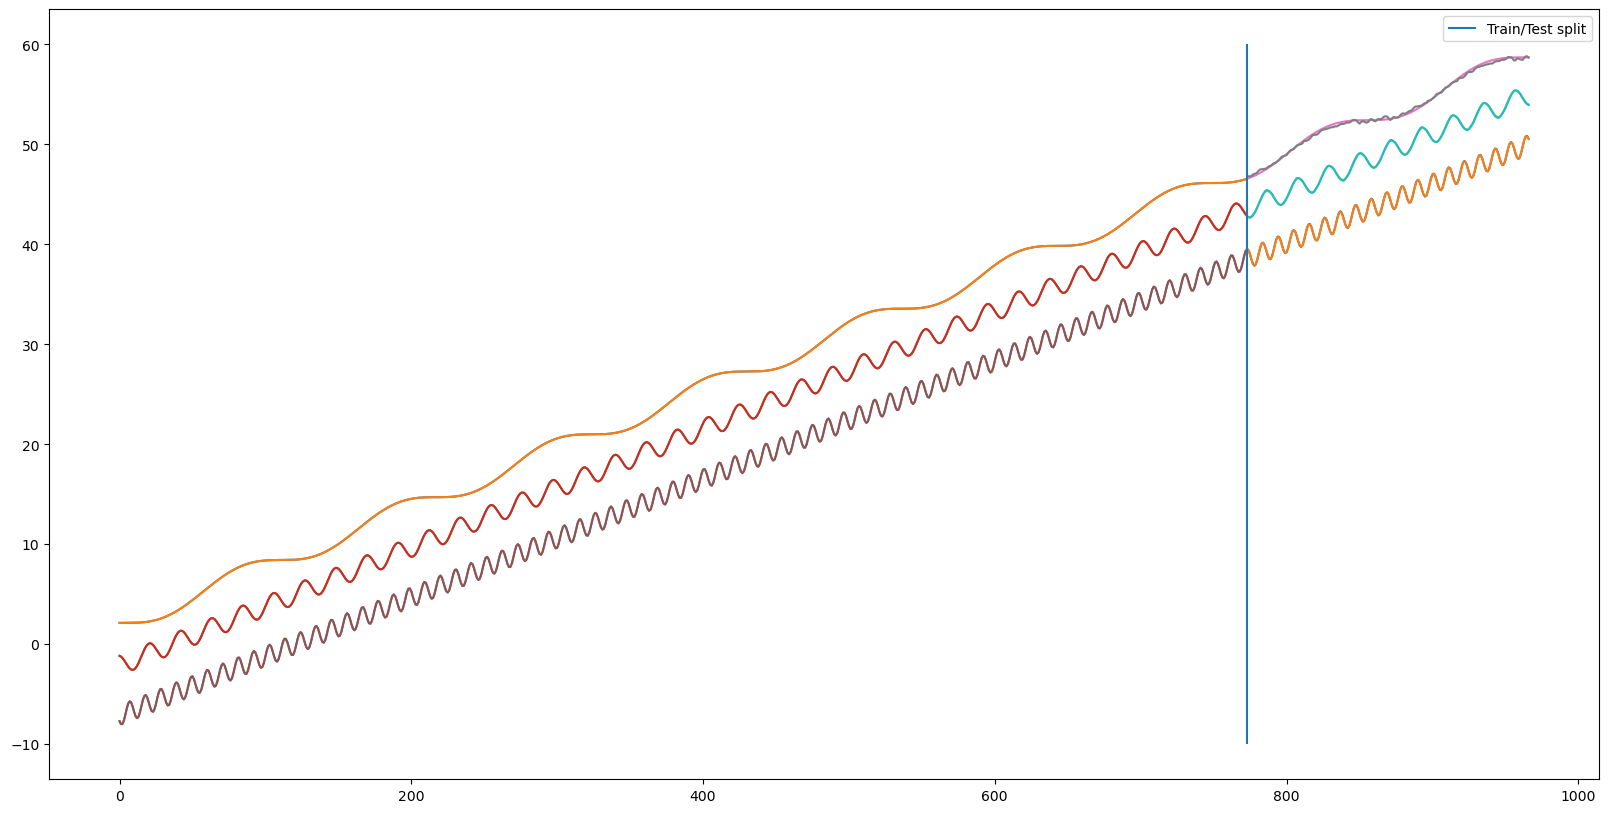

In [13]:
plt.figure(figsize=(20, 10))

plt.plot(train_idx, train_true[:,0, 0])
plt.plot(train_idx, train_true[:,0, 0])

plt.plot(train_idx, train_true[:,0, 1])
plt.plot(train_idx, train_true[:,0, 1])

plt.plot(train_idx, train_true[:,0, 2])
plt.plot(train_idx, train_true[:,0, 2])


plt.plot(test_idx, test_true[:,0, 0])
plt.plot(test_idx, test_tar[:,0, 0])

plt.plot(test_idx, test_true[:,0, 1])
plt.plot(test_idx, test_tar[:,0, 1])

plt.plot(test_idx, test_true[:,0, 2])
plt.plot(test_idx, test_tar[:,0, 2])

plt.vlines(x=test_idx[0], ymax=60, ymin=-10, label="Train/Test split")
plt.legend()